# Time Series Forecasting

In [ ]:
from zipfile import ZipFile

with ZipFile('/content/delhi-weather-data.zip', 'r') as zipObj:
   zipObj.extractall()

In [ ]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns, graphviz

In [ ]:
df = pd.read_csv("/content/testset.csv")

In [67]:
df.head()

,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
0,19961101-11:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1,19961101-12:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
2,19961101-13:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
3,19961101-14:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
4,19961101-16:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0


In [ ]:
df[' _conds'].value_counts()

# Time Series Forecasting

In [ ]:
# taking only temperature feature as values and datetime feature as index in the dataframe for time series forecasting of temperature
data = pd.DataFrame(list(df[' _tempm']), index=df['datetime_utc'], columns=['temp'])

In [90]:
data

,temp
datetime_utc,
1996-11-01 11:00:00,30.0
1996-11-01 12:00:00,28.0
1996-11-01 13:00:00,24.0
1996-11-01 14:00:00,24.0
1996-11-01 16:00:00,23.0
...,...
2017-04-24 06:00:00,34.0
2017-04-24 09:00:00,38.0
2017-04-24 12:00:00,36.0


In [95]:
data.shape

(7480, 1)

In [96]:
data

,temp
datetime_utc,
1996-11-01,22.333333
1996-11-02,22.916667
1996-11-03,21.791667
1996-11-04,22.722222
1996-11-05,27.800000
...,...
2017-04-20,34.500000
2017-04-21,34.250000
2017-04-22,32.900000


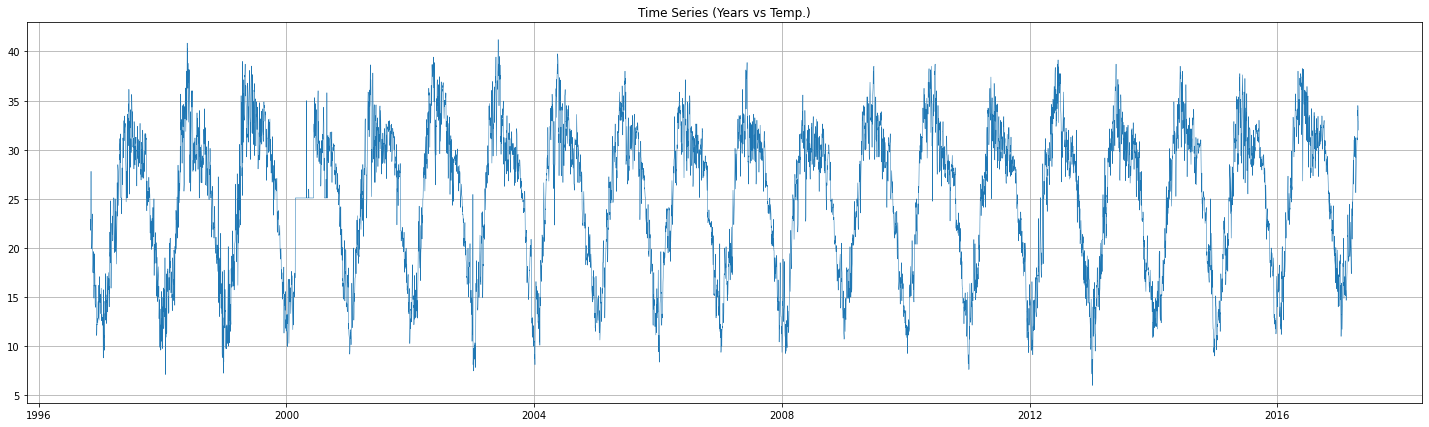

In [97]:
plt.figure(figsize=(25, 7))
plt.plot(data, linewidth=.5)
plt.grid()
plt.title("Time Series (Years vs Temp.)")
plt.show()

In [ ]:
# Scaling data to get rid of outliers
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler(feature_range=(-1,1))
data_scaled = scalar.fit_transform(data)

In [99]:
data_scaled

array([[-0.07224714],
       [-0.0391131 ],
       [-0.10301445],
       ...,
       [ 0.52795217],
       [ 0.52653214],
       [ 0.47683109]])

In [100]:
data_scaled.shape

(7480, 1)

In [ ]:
timestep = 30
X, Y = [], []
for i in range(len(data_scaled)- (timestep)):
    X.append(data_scaled[i:i+timestep])
    Y.append(data_scaled[i+timestep])

In [ ]:
X, Y = np.asanyarray(X), np.asanyarray(Y)

In [ ]:
k = 7300
Xtrain, Xtest = X[:k,:,:], X[k:,:,:]    
Ytrain, Ytest = Y[:k], Y[k:] 

In [104]:
X.shape

(7450, 30, 1)

In [105]:
Xtrain.shape

(7300, 30, 1)

In [106]:
Xtest.shape

(150, 30, 1)

In [ ]:
from keras.layers import Dense,RepeatVector, LSTM, Dropout, Flatten, TimeDistributed, Conv1D, MaxPooling1D, Bidirectional
from keras.models import Sequential

In [54]:
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(30,1)))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(30))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(LSTM(units=100, return_sequences=True))
model.add(Bidirectional(LSTM(128, activation='relu')))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
history = model.fit(Xtrain,Ytrain,epochs=300, verbose=1 )

Epoch 1/300
229/229 [==============================] - 26s 113ms/step - loss: 0.0199
Epoch 2/300
229/229 [==============================] - 26s 112ms/step - loss: 0.0118
Epoch 3/300
229/229 [==============================] - 25s 110ms/step - loss: 0.0115
Epoch 4/300
229/229 [==============================] - 25s 109ms/step - loss: 0.0107
Epoch 5/300
229/229 [==============================] - 25s 111ms/step - loss: 0.0110
Epoch 6/300
229/229 [==============================] - 26s 112ms/step - loss: 0.0103
Epoch 7/300
229/229 [==============================] - 25s 111ms/step - loss: 0.0103
Epoch 8/300
229/229 [==============================] - 28s 121ms/step - loss: 0.0102
Epoch 9/300
229/229 [==============================] - 25s 110ms/step - loss: 0.0101
Epoch 10/300
229/229 [==============================] - 26s 111ms/step - loss: 0.0103
Epoch 11/300
229/229 [==============================] - 25s 111ms/step - loss: 0.0099
Epoch 12/300
229/229 [==============================] - 26s 112

In [ ]:
model.save("./regressor.hdf5")

In [ ]:
predict = scalar.inverse_transform(model.predict(Xtest))

In [ ]:
Ytesting = scalar.inverse_transform(Ytest)

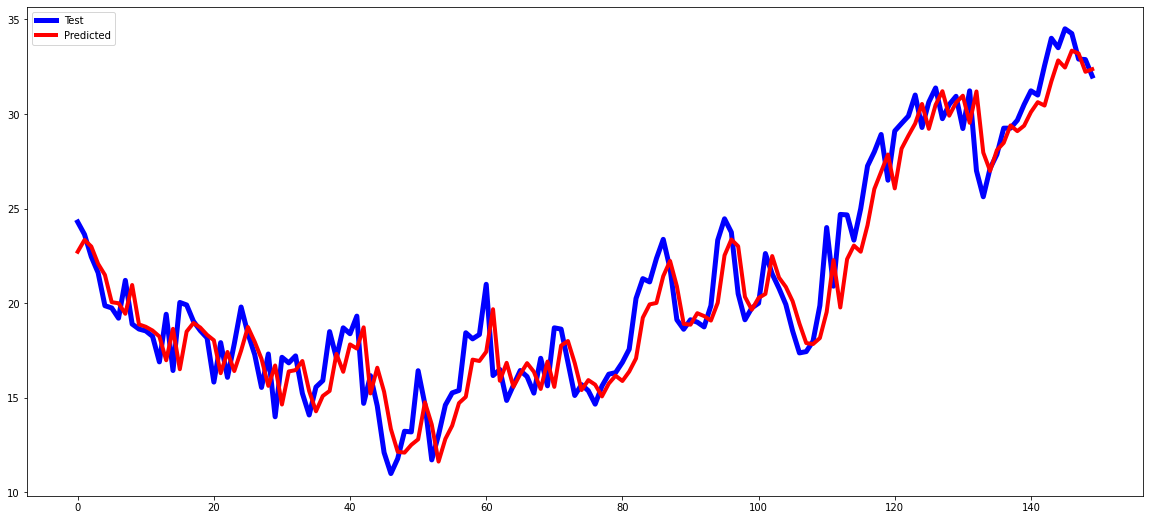

In [60]:
plt.figure(figsize=(20,9))
plt.plot(Ytesting , 'blue', linewidth=5)
plt.plot(predict,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.show()

In [61]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Ytesting, predict)

2.992469732353368